In [287]:
import cv2
import os
import numpy as np
from skimage.feature import hog, graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models, regularizers


In [288]:
import os
import cv2
import numpy as np
import random

def load_dataset(preprocessed_img_dir, img_size=(224, 224), sample_fraction=0.2):
    images = []
    labels = []

    class_mapping = {'animals': 1, 'non-animals': 0}

    for folder in os.listdir(preprocessed_img_dir):
        folder_path = os.path.join(preprocessed_img_dir, folder)

        if os.path.isdir(folder_path) and folder in class_mapping:
            label = class_mapping[folder]
            print(f"Assigning label {label} to folder {folder}")

            img_paths = []

            # If it's an animal category, process subfolders
            for subfolder in [os.path.join(folder_path, sf) for sf in os.listdir(folder_path)]:
                if os.path.isdir(subfolder):
                    img_paths.extend([os.path.join(subfolder, img) for img in os.listdir(subfolder)])
            
            # If it's 'non-animals', process files directly inside the folder
            if not img_paths:
                img_paths = [os.path.join(folder_path, img) for img in os.listdir(folder_path)]

            sampled_paths = random.sample(img_paths, int(len(img_paths) * sample_fraction))

            for img_path in sampled_paths:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"Failed to load image: {img_path}")
                    continue
                img = cv2.resize(img, img_size)
                images.append(img / 255.0)  # Normalize
                labels.append(label)

    print(f"Total images loaded: {len(images)}")
    print(f"Unique classes in labels: {np.unique(labels)}")
    return np.array(images), np.array(labels)


In [289]:
preprocessed_img_dir = '/Users/resindunavoda/PycharmProjects/Wild_Animal_Detection/Dataset/Output'
X, y = load_dataset(preprocessed_img_dir)

Assigning label 0 to folder non-animals
Assigning label 1 to folder animals
Total images loaded: 5375
Unique classes in labels: [0 1]


In [290]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check class balance
print(f"Training class distribution: {np.bincount(y_train)}")
print(f"Testing class distribution: {np.bincount(y_test)}")
print(f"Unique classes in y_train: {np.unique(y_train)}")


Training class distribution: [2567 1733]
Testing class distribution: [642 433]
Unique classes in y_train: [0 1]


In [291]:
for label, folder in enumerate(os.listdir(preprocessed_img_dir)):
    folder_path = os.path.join(preprocessed_img_dir, folder)
    if os.path.isdir(folder_path):
        print(f"Label: {label}, Folder: {folder}, Image count: {len(os.listdir(folder_path))}")


Label: 1, Folder: non-animals, Image count: 16048
Label: 2, Folder: animals, Image count: 12


In [292]:
def check_class_distribution(y):
    unique, counts = np.unique(y, return_counts=True)
    print("Class distribution:", dict(zip(unique, counts)))
    
check_class_distribution(y)


Class distribution: {np.int64(0): np.int64(3209), np.int64(1): np.int64(2166)}


#CNN model


In [293]:
def build_model(input_shape=(224, 224, 1)):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape,
                            kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model# Build and assign the model
cnn_model = build_model()


/Users/resindunavoda/PycharmProjects/Wild_Animal_Detection/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [294]:
history = cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 95s 693ms/step - accuracy: 0.6002 - loss: 1.1179 - val_accuracy: 0.7637 - val_loss: 0.6725
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 92s 678ms/step - accuracy: 0.7741 - loss: 0.6195 - val_accuracy: 0.8177 - val_loss: 0.5669
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 91s 675ms/step - accuracy: 0.8271 - loss: 0.5194 - val_accuracy: 0.8874 - val_loss: 0.4178
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 98s 725ms/step - accuracy: 0.8612 - loss: 0.4417 - val_accuracy: 0.8800 - val_loss: 0.4111
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 95s 703ms/step - accuracy: 0.8874 - loss: 0.4011 - val_accuracy: 0.8726 - val_loss: 0.4022
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 91s 670ms/step - accuracy: 0.8795 - loss: 0.4069 - val_accuracy: 0.8856 - val_loss: 0.3859
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 95s 701ms/step - accuracy: 0.8806 - loss: 0.3927 - val_accuracy: 0.8828 - val_loss: 0.4083
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 91s 673ms/step - accuracy: 0.8815 - loss: 0

#prediction

In [295]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_image(img_path, cnn_model=None, img_size=(224, 224)):
    # Load the thermal image (grayscale)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Could not load image!")
        return None

    # Resize image to the size expected by the CNN
    img_resized = cv2.resize(img, img_size)

    # Debug: Check the image shape
    print(f"Image shape after resize: {img_resized.shape}")

    # Normalize and prepare the image for CNN
    img_normalized = img_resized / 255.0  # Normalize the pixel values

    # Add an extra dimension for channels (height, width, channels)
    img_cnn = np.expand_dims(img_normalized, axis=-1)  # Shape: (224, 224, 1)

    # Add batch dimension (1, height, width, channels)
    img_cnn = np.expand_dims(img_cnn, axis=0)  # Shape: (1, 224, 224, 1)

    # Debug: Check the shape before feeding it to the CNN
    print(f"Shape of image going into CNN: {img_cnn.shape}")

    # Check the CNN model's expected input shape
    print(f"Expected input shape by CNN model: {cnn_model.input_shape}")

    predictions = {}

    # If CNN model is provided, process and predict 
    if cnn_model:
        try:
            cnn_pred = cnn_model.predict(img_cnn)[0][0]  # Get prediction value
            print(f"CNN prediction: {cnn_pred}")
            predictions["cnn"] = "Animal" if cnn_pred >= 0.5 else "No Animal"
        except Exception as e:
            print(f"Error during CNN prediction: {e}")
            predictions["cnn"] = "Error"

    return predictions

# # Example Usage:
# img_path = '/Users/resindunavoda/PycharmProjects/Wild_Animal_Detection/dee.jpg'
# result = predict_image(img_path, cnn_model=cnn_model)
# print(f"Prediction: {result}")


#Model evaluation


In [296]:
# Evaluate the model on the test set
test_loss, test_acc = cnn_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.8791 - loss: 0.4008
Test accuracy: 89.21%


In [297]:
print(f"Shape of X_test: {X_test.shape}")


Shape of X_test: (1075, 224, 224)


In [298]:
X_test = X_test.reshape(-1, 224, 224, 1)  # Add channel dimension

# Predict probabilities
y_pred_probs = cnn_model.predict(X_test)

# Convert to binary (0 or 1) using a threshold of 0.5
y_pred_cnn = (y_pred_probs > 0.5).astype(int)
print(classification_report(y_test, y_pred_cnn))


34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       642
           1       0.91      0.81      0.86       433

    accuracy                           0.89      1075
   macro avg       0.90      0.88      0.89      1075
weighted avg       0.89      0.89      0.89      1075



In [299]:
img_path = '/Users/resindunavoda/PycharmProjects/Wild_Animal_Detection/dee.jpg'
# model = model
result = predict_image(img_path, cnn_model)
print(f"Prediction: {result}")

Image shape after resize: (224, 224)
Shape of image going into CNN: (1, 224, 224, 1)
Expected input shape by CNN model: (None, 224, 224, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
CNN prediction: 0.9712620973587036
Prediction: {'cnn': 'Animal'}


Compute Precision, Recall, and F1-score


In [300]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate metrics
precision = precision_score(y_test, y_pred_cnn)
recall = recall_score(y_test, y_pred_cnn)
f1 = f1_score(y_test, y_pred_cnn)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Precision: 0.9138
Recall: 0.8083
F1-Score: 0.8578


Plot the Confusion Matrix

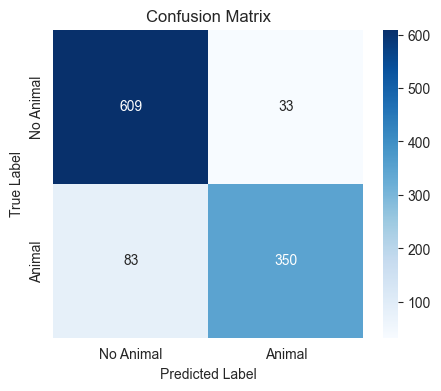

In [301]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_cnn)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Animal", "Animal"], yticklabels=["No Animal", "Animal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Plot the ROC Curve (For Probability-Based Analysis)


34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step


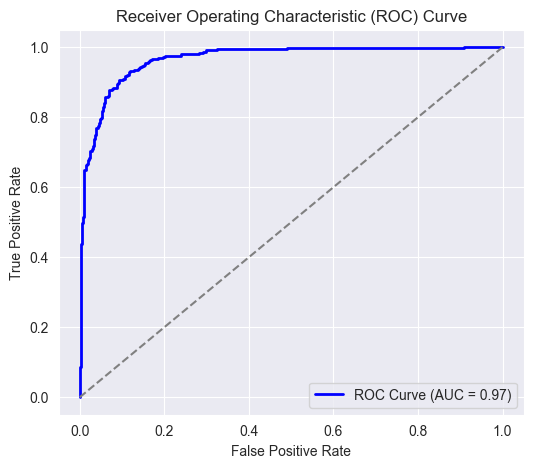

In [302]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities
y_pred_probs = cnn_model.predict(X_test).ravel()

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal line (random guessing)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


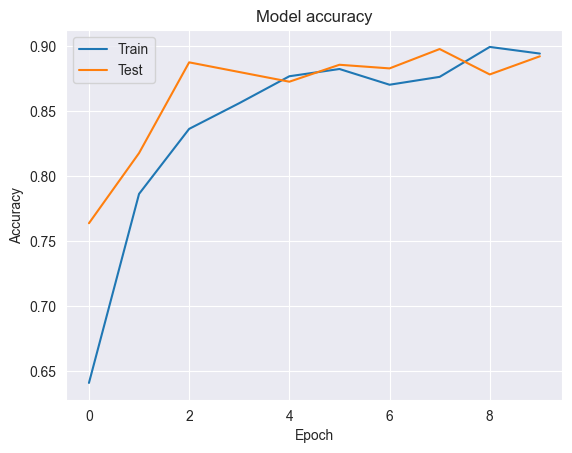

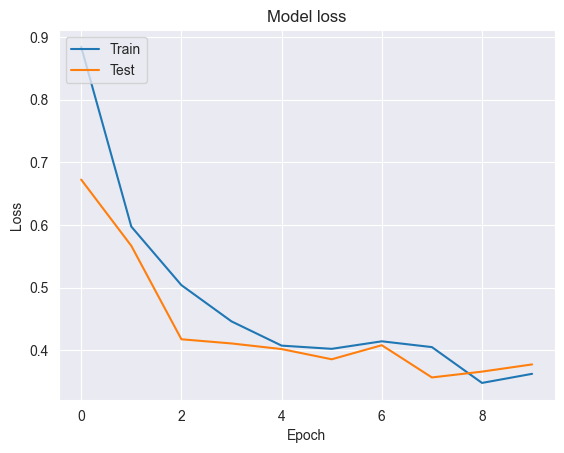

In [303]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#SVM



In [304]:
# Extract HOG features
def extract_hog_features(images):
    hog_features = []
    for img in tqdm(images, desc="Extracting HOG features"):
        if len(img.shape) == 3:  # Check if image has a channel dimension
            img = img.squeeze()  # Remove channel dimension if present
        features = hog(img, orientations=9, pixels_per_cell=(8, 8), 
                       cells_per_block=(2, 2), feature_vector=True)
        hog_features.append(features)
    return np.array(hog_features)

In [305]:

# HOG + SVM pipeline
#Histogram of Oriented Gradients(used to extracts shape-based features)
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train_hog, y_train)
y_pred_svm = svm_model.predict(X_test_hog)

print("\nSVM with HOG Features")
print(classification_report(y_test, y_pred_svm))
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm) * 100:.2f}%")




Extracting HOG features: 100%|██████████| 1075/1075 [00:10<00:00, 102.40it/s]



SVM with HOG Features
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       642
           1       0.84      0.85      0.84       433

    accuracy                           0.87      1075
   macro avg       0.87      0.87      0.87      1075
weighted avg       0.87      0.87      0.87      1075

Accuracy: 87.26%


In [306]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
# Calculate metrics
precision = precision_score(y_test, y_pred_cnn)
recall = recall_score(y_test, y_pred_cnn)
f1 = f1_score(y_test, y_pred_cnn)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# print(f"Confusion Matrix:\n{cm}")


Precision: 0.9138
Recall: 0.8083
F1-Score: 0.8578


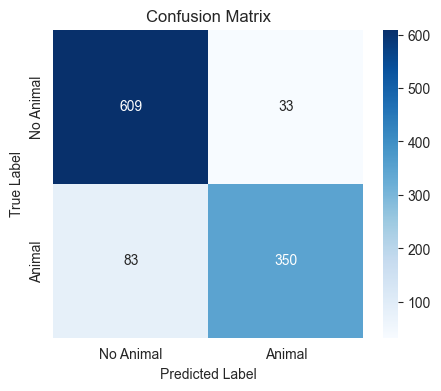

In [307]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Animal", "Animal"], yticklabels=["No Animal", "Animal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


#Random Forest


In [308]:
# def extract_glcm_features(images):
#     glcm_features = []
#     for img in tqdm(images, desc="Extracting GLCM features"):
#         glcm = graycomatrix((img * 255).astype(np.uint8), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
#         contrast = graycoprops(glcm, 'contrast')[0, 0]
#         dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
#         homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
#         energy = graycoprops(glcm, 'energy')[0, 0]
#         correlation = graycoprops(glcm, 'correlation')[0, 0]
#         glcm_features.append([contrast, dissimilarity, homogeneity, energy, correlation])
#     return np.array(glcm_features)

In [309]:
def extract_glcm_features(images):
    glcm_features = []
    for img in tqdm(images, desc="Extracting GLCM features"):
        if img.ndim == 3:  # Remove extra channel if present
            img = img.squeeze()

        if img.ndim != 2:  # Ensure image is 2D
            raise ValueError(f"Unexpected image shape {img.shape}, expected (height, width)")

        img_uint8 = (img * 255).astype(np.uint8) if img.max() <= 1 else img.astype(np.uint8)

        glcm = graycomatrix(img_uint8, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]

        glcm_features.append([contrast, dissimilarity, homogeneity, energy, correlation])

    return np.array(glcm_features)

In [310]:
# GLCM + Random Forest pipeline
#Gray-Level Co-occurrence Matrix(used to extracts texture)
X_train_glcm = extract_glcm_features(X_train)
X_test_glcm = extract_glcm_features(X_test)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_glcm, y_train)
y_pred_rf = rf_model.predict(X_test_glcm)




Extracting GLCM features: 100%|██████████| 1075/1075 [00:02<00:00, 400.43it/s]


#Random Forest+GLCM Evaluation

In [311]:
print("\nRandom Forest with GLCM Features")
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf) * 100:.2f}%")


Random Forest with GLCM Features
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       642
           1       0.81      0.83      0.82       433

    accuracy                           0.85      1075
   macro avg       0.84      0.85      0.85      1075
weighted avg       0.85      0.85      0.85      1075

Accuracy: 85.12%


In [312]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate Precision, Recall, and F1-Score
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)

# Print the evaluation metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Precision: 0.8081
Recall: 0.8268
F1-Score: 0.8174


#Prediction

In [313]:
import cv2
import numpy as np
from skimage.feature import hog, graycomatrix, graycoprops
from tensorflow.keras.preprocessing import image
from tqdm import tqdm


# Main prediction function
def predict_image(img_path, cnn_model=None, svm_model=None, rf_model=None, img_size=(224, 224)):
    # Load the thermal image (grayscale)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Could not load image!")
        return {'cnn': 'Error', 'svm': 'Error', 'rf': 'Error'}

    # Resize image to the size expected by the CNN and other models
    img_resized = cv2.resize(img, img_size)

    # Debug: Check the image shape
    print(f"Image shape after resize: {img_resized.shape}")

    # Normalize the image for CNN
    img_normalized = img_resized / 255.0  # Normalize the pixel values
    
    # Prepare image for CNN (adding channel and batch dimensions)
    img_cnn = np.expand_dims(img_normalized, axis=-1)  # Shape: (224, 224, 1)
    img_cnn = np.expand_dims(img_cnn, axis=0)  # Shape: (1, 224, 224, 1)
    
    # Extract HOG features for SVM
    hog_features = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), feature_vector=True).reshape(1, -1)

    # Extract GLCM features for Random Forest
    glcm_features = extract_glcm_features([img_resized])

    # Store predictions in a dictionary
    predictions = {}

    # CNN prediction (if CNN model is provided)
    if cnn_model:
        try:
            cnn_pred = cnn_model.predict(img_cnn)[0][0]  # Get the prediction
            predictions["cnn"] = "Animal" if cnn_pred >= 0.5 else "No Animal"
        except Exception as e:
            print(f"Error during CNN prediction: {e}")
            predictions["cnn"] = "Error"

    # SVM prediction (if SVM model is provided)
    if svm_model:
        try:
            svm_pred = svm_model.predict(hog_features)[0]
            predictions["svm"] = "Animal" if svm_pred == 1 else "No Animal"
        except Exception as e:
            print(f"Error during SVM prediction: {e}")
            predictions["svm"] = "Error"

    # Random Forest prediction (if Random Forest model is provided)
    if rf_model:
        try:
            rf_pred = rf_model.predict(glcm_features)[0]
            predictions["rf"] = "Animal" if rf_pred == 1 else "No Animal"
        except Exception as e:
            print(f"Error during Random Forest prediction: {e}")
            predictions["rf"] = "Error"

    return predictions


In [314]:
img_path = '/Users/resindunavoda/PycharmProjects/Wild_Animal_Detection/dee.jpg'
result = predict_image(img_path, cnn_model=cnn_model, svm_model=svm_model, rf_model=rf_model)
print(result)

Image shape after resize: (224, 224)


Extracting GLCM features: 100%|██████████| 1/1 [00:00<00:00, 515.21it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
{'cnn': 'Animal', 'svm': 'Animal', 'rf': 'Animal'}


In [317]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

# Function to calculate performance metrics
def get_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = report["1"]["precision"]  # Assuming '1' is the positive class
    recall = report["1"]["recall"]
    f1_score = report["1"]["f1-score"]
    return round(accuracy, 2), round(precision, 4), round(recall, 4), round(f1_score, 4)

# Compute metrics for each model
cnn_metrics = get_metrics(y_test, y_pred_cnn)
svm_metrics = get_metrics(y_test, y_pred_svm)
rf_metrics = get_metrics(y_test, y_pred_rf)

# Create a comparison DataFrame
model_comparison = pd.DataFrame({
    "Model": ["CNN", "SVM (HOG)", "Random Forest (GLCM)"],
    "Feature Type": ["Raw Image (224x224)", "HOG", "GLCM"],
    "Classifier": ["Deep Learning (CNN)", "Support Vector Machine", "Random Forest"],
    "Accuracy (%)": [cnn_metrics[0], svm_metrics[0], rf_metrics[0]],
    "Precision": [cnn_metrics[1], svm_metrics[1], rf_metrics[1]],
    "Recall": [cnn_metrics[2], svm_metrics[2], rf_metrics[2]],
    "F1-Score": [cnn_metrics[3], svm_metrics[3], rf_metrics[3]]
})

# Stylish formatting for better display
pd.set_option('display.colheader_justify', 'center')  # Center the column headers
print("\n📊 Model Performance Comparison\n")
print(model_comparison.to_markdown(index=False))



📊 Model Performance Comparison

| Model                | Feature Type        | Classifier             |   Accuracy (%) |   Precision |   Recall |   F1-Score |
|:---------------------|:--------------------|:-----------------------|---------------:|------------:|---------:|-----------:|
| CNN                  | Raw Image (224x224) | Deep Learning (CNN)    |          89.21 |      0.9138 |   0.8083 |     0.8578 |
| SVM (HOG)            | HOG                 | Support Vector Machine |          87.26 |      0.8394 |   0.8453 |     0.8423 |
| Random Forest (GLCM) | GLCM                | Random Forest          |          85.12 |      0.8081 |   0.8268 |     0.8174 |
